In [2]:
from networkx import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
import os
from datetime import datetime as dt
from data_reader import get_stackoverflow_data
from fix_edge_ids import fix_graphml_edges

BASE_PATH = 'data'

# The second value indicates if it's numerical
wanted_user_attributes = [('Reputation', True), ('UpVotes', True), ('DownVotes', True)]
user_question_counter = defaultdict(int)

def get_posts_from_last_five_years(posts):
    # post creation dates are in form 2011-08-30T21:12:34.090 but lets only Y-m-d
    start = "2017-01-01"

    # returns True if date is after start date
    def filter_func(post):
        date = post.attrib.get('CreationDate')[:10]
        return dt.strptime(start, "%Y-%m-%d") < dt.strptime(date, "%Y-%m-%d")

    return list(filter(filter_func, posts))

for directory in os.listdir(BASE_PATH):
    print('Searching', directory)
    
    MDG = nx.MultiDiGraph()
    
    edges = dict()
    missing_users = set()
    nodes = defaultdict(dict)
    
    question_asker = dict()
    users = defaultdict(dict)
    user_row_ids = dict()
    xml_data = get_stackoverflow_data(os.path.join(BASE_PATH, directory), ['Posts', 'Users'])

    for user in xml_data['Users']:
        account_id = user.attrib.get('AccountId', user.attrib['DisplayName'])
        row_id = user.attrib.get('Id')
        user_row_ids[row_id] = account_id
        # Wanted features
        for attribute, numerical in wanted_user_attributes:
            fetched_attribute = user.attrib.get(attribute)
            if numerical:
                fetched_attribute = int(fetched_attribute)
            users[account_id][attribute] = fetched_attribute

    print("Number of posts before filtering by date: " + str(len(xml_data['Posts'])))
    xml_data['Posts'] = get_posts_from_last_five_years(xml_data['Posts'])
    print("Number of posts after filtering by date: " + str(len(xml_data['Posts'])))

    for row in xml_data['Posts']:
        # PostTypeId == 1 indicates that it's a question
        if row.attrib['PostTypeId'] == '1':
            user_id = user_row_ids.get(row.attrib.get('OwnerUserId')) or row.attrib.get('OwnerDisplayName')
            question_asker[row.attrib['Id']] = user_id
            user_question_counter[user_id] += 1

    # There are cases of answers with a lower Id than the question, hence one further loop
    for row in xml_data['Posts']:
        # PostTypeId == 2 is an answer
        if row.attrib['PostTypeId'] == '2':
            # question_asker might not exist if only posts from past X years were used
            if not row.attrib['ParentId'] in question_asker:
                continue
            parent_user_id = question_asker[row.attrib['ParentId']]
            # fetches the id of the OP and links them
            user_id = user_row_ids.get(row.attrib.get('OwnerUserId')) or row.attrib.get('OwnerDisplayName')
            creation_date = row.attrib.get('CreationDate')
            for user in user_id, parent_user_id:
                nodes[user] = users.get(user)

            # setdefault seems to be faster than defaultdict in this case
            edges.setdefault((user_id, parent_user_id), dict())[directory] = []
            edges[(user_id, parent_user_id)][directory].append(creation_date)


    # This will be in the format:
    #   (answerer, questioner, {'site': <name_of_the_site>, 'weight': <number_of_answers>}add_edges_from)
    MDG.add_edges_from([(*k, {'site':k2, 'weight':len(v2)}) for k, v in edges.items() for k2, v2 in v.items()])

    MDG.add_nodes_from(nodes)
    for node in MDG.nodes:
        MDG.nodes[node]['questions'] = user_question_counter[node]

nx.write_graphml(MDG, "graphml/combination.graphml")
 
fix_graphml_edges()

Searching economics
Number of posts before filtering by date: 16691
Number of posts after filtering by date: 7690
Searching crypto
Number of posts before filtering by date: 41841
Number of posts after filtering by date: 14848
Searching bitcoin
Number of posts before filtering by date: 53197
Number of posts after filtering by date: 22323


In [13]:
MDG.edges

OutMultiEdgeView([('5455814', '6357790', 0), ('5455814', '6357790', 1), ('5455814', '6357790', 2), ('5455814', '8800476', 0), ('5455814', '8800476', 1), ('5455814', '8800476', 2), ('5455814', '9799987', 0), ('5455814', '9799987', 1), ('5455814', '9799987', 2), ('5455814', '5923353', 0), ('5455814', '5923353', 1), ('5455814', '5923353', 2), ('5455814', '9366500', 0), ('5455814', '9366500', 1), ('5455814', '9366500', 2), ('5455814', '1193549', 0), ('5455814', '1193549', 1), ('5455814', '1193549', 2), ('5455814', '7506118', 0), ('5455814', '7506118', 1), ('5455814', '7506118', 2), ('5455814', '9046064', 0), ('5455814', '9046064', 1), ('5455814', '9046064', 2), ('5455814', '7317061', 0), ('5455814', '7317061', 1), ('5455814', '7317061', 2), ('5455814', '22756', 0), ('5455814', '22756', 1), ('5455814', '22756', 2), ('5455814', '10141519', 0), ('5455814', '10141519', 1), ('5455814', '10141519', 2), ('5455814', '9200629', 0), ('5455814', '9200629', 1), ('5455814', '9200629', 2), ('5455814', '

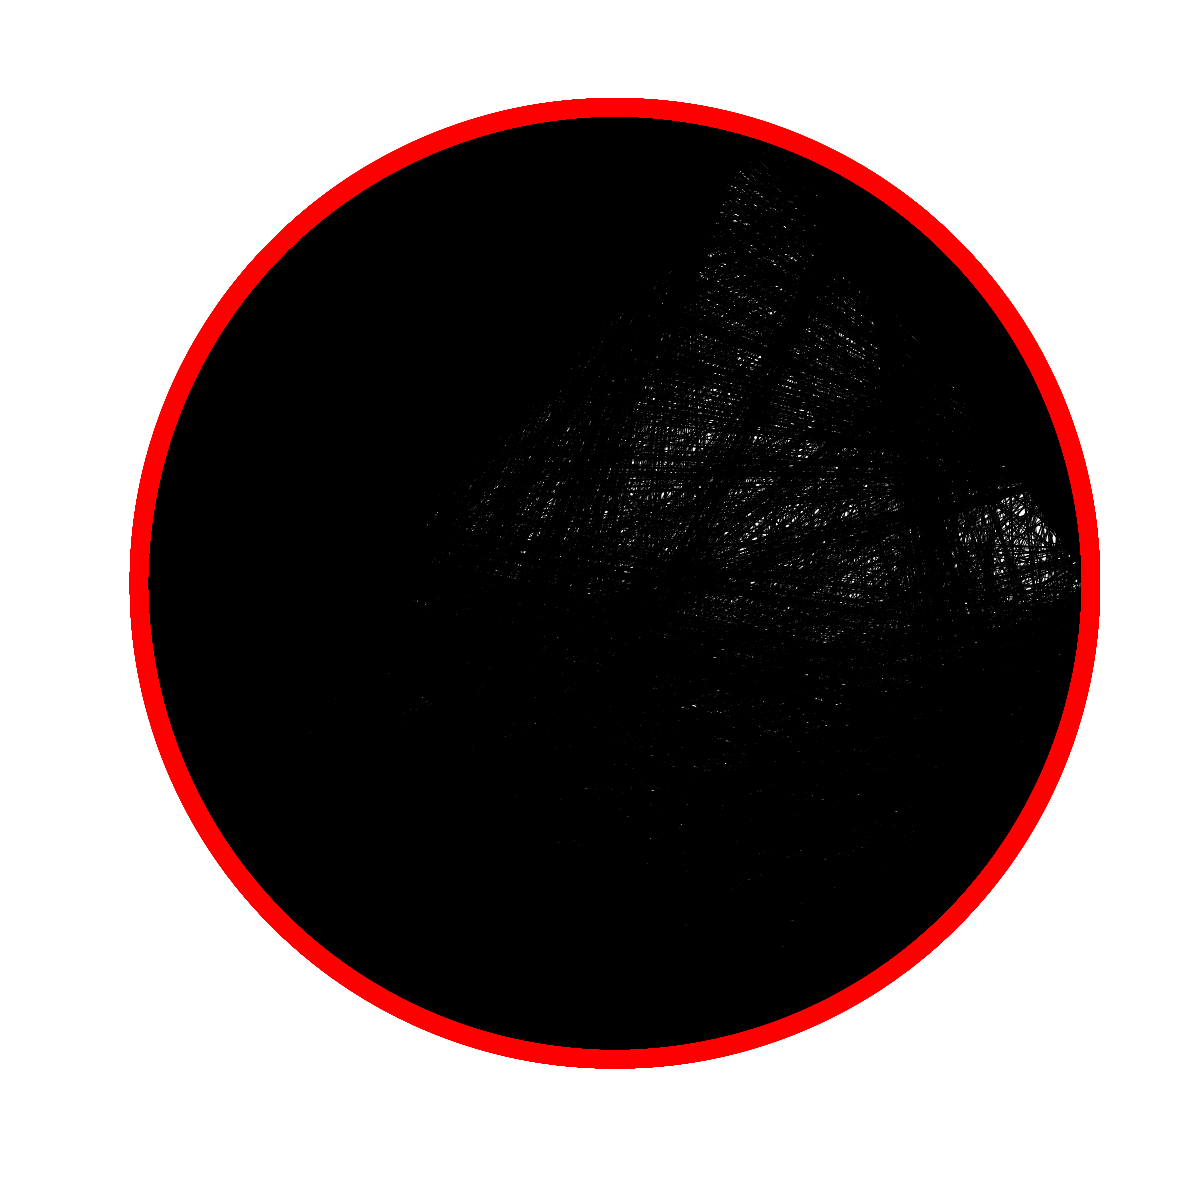

In [3]:
plt.figure(1, figsize=(16,16))
#nx.draw(G, with_labels=True, node_color='skyblue', width=weights)
#plt.show()
#nx.write_graphml(MDG, "bitcoin.graphml")

nx.draw_circular(MDG)

In [12]:
closeness = nx.algorithms.closeness_centrality(G)

In [40]:
nodes_with_reputation = { k:int(v['Reputation']) for k, v in nodes.items() if v }
node_closeness = { k: closeness[k] for k in nodes_with_reputation }

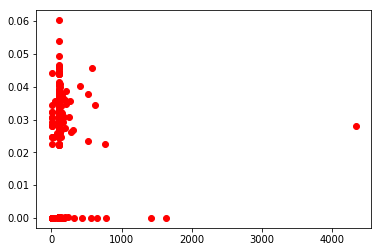

In [41]:
ks = sorted(nodes_with_reputation, key=nodes_with_reputation.get)
f = plt.figure()
plt.plot([nodes_with_reputation[k] for k in ks], [node_closeness[k] for k in ks], 'ro')
plt.show()
f.savefig("plot.pdf", bbox_inches='tight')

In [47]:
ks
sum(1 for k in nodes_with_reputation.values() if k == 101) / len(nodes_with_reputation)

0.7121848739495799